# Flight Delays
## Due Tuesday, May 2

In this lab, we will explore a big data set (2.2 GB) consisting of all flights in the United States between 2004-8. This data is stored in a SQLite database on the server. The path to the file is `/data/flights.db`. The data about the flights is contained in a table called `ontime`. A description of the columns in the data set can be found in `/data/flights.README`.

Furthermore, there is a table called `planes` in the same database containing information about the planes, such as their age. Description of the columns in these two tables can be found [here](http://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/media/ardata.pdf).

Start this assignment early, as each SQL query can take a few minutes to run (and you may need to try a question several times to get the right answer).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
f = open("/data/flights.README", "rt")
f.read()

'Name\tDescription\n1\tYear\t\t\t2004-2008\n2\tMonth\t\t\t1-12\n3\tDayofMonth\t\t1-31\n4\tDayOfWeek\t\t1 (Monday) - 7 (Sunday)\n5\tDepTime\t\t\tactual departure time (local, hhmm)\n6\tCRSDepTime\t\tscheduled departure time (local, hhmm)\n7\tArrTime\t\t\tactual arrival time (local, hhmm)\n8\tCRSArrTime\t\tscheduled arrival time (local, hhmm)\n9\tUniqueCarrier\t\tunique carrier code\n10\tFlightNum\t\tflight number\n11\tTailNum\t\t\tplane tail number\n12\tActualElapsedTime     \tin minutes\n13\tCRSElapsedTime\t      \tin minutes\n14\tAirTime\t\t      \tin minutes\n15\tArrDelay\t      \tarrival delay, in minutes\n16\tDepDelay\t      \tdeparture delay, in minutes\n17\tOrigin\t\t      \torigin IATA airport code\n18\tDest\t\t      \tdestination IATA airport code\n19\tDistance\t      \tin miles\n20\tTaxiIn\t\t      \ttaxi in time, in minutes\n21\tTaxiOut\t\t      \ttaxi out time in minutes\n22\tCancelled\t      \twas the flight cancelled?\n23\tCancellationCode      \treason for cancellation (A

## Question 0 (5 points)

In the cell below, use SQLAlchemy to create a connection to the database. Store the connection in a variable `conn`.

In [2]:
from sqlalchemy import create_engine
conn = create_engine("sqlite:////data/flights.db")

In [3]:
# If your code above was correct, the tests below should pass.

num_flights = pd.read_sql("SELECT COUNT(*) FROM ontime", conn)
assert(num_flights.ix[0, 0] == 28745461)

num_planes = pd.read_sql("SELECT COUNT(*) FROM planes", conn)
assert(num_planes.ix[0, 0] == 317017)

## Question 1 (10 points)

Calculate the total number of flights in each year (2004-2008), and make a line plot showing this data. Do you notice any trends?

In [4]:
query = '''
select count(*), year
from ontime
group by year
'''
flight_year = pd.read_sql(query, conn)

In [5]:
flight_year.head()


,count(*),Year
0,7140596,2005
1,7141922,2006
2,7453215,2007
3,7009728,2008


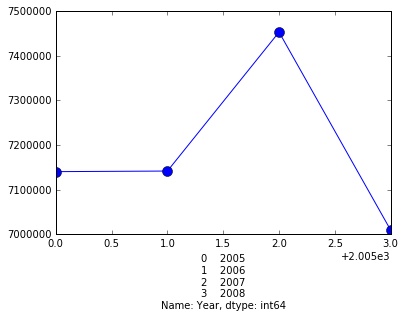

In [6]:
plt.plot(flight_year.Year, flight_year['count(*)'], "-o", markersize = 10)
plt.xlabel(flight_year.Year)

__ANSWER__ yes we can see that the ht eyears 2005 and 2006 had roughly the same amount of flights. There was a huge rise in flights in 2007 by roughly 300,000 flights. IN 2008 though , the amount of flights sharpely declined to a low of 7000000 which is almoast 100,0000 flights less than in 2005. 

## Question 2 (10 points)

What time of day is best to fly if you want to avoid delays? Calculate the average delay by _scheduled_ departure time. What do you notice?

In [7]:
query = '''
select CRSDepTime, AVG(DepDelay) as average_delay, Count(CRSDepTime), (DepDelay -  AVG(DepDelay)) * (DepDelay -  AVG(DepDelay)) as unsqvar
from ontime
group by CRSDepTime
'''
avg_delay = pd.read_sql(query, conn)



In [8]:
import math
from scipy.stats import t 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
avg_delay['var'] = (avg_delay.unsqvar) / avg_delay['Count(CRSDepTime)']
avg_delay['stddev'] = avg_delay['var'] ** .5 
quart = np.percentile(avg_delay['Count(CRSDepTime)'], 25)


avg_delay
avg_delay['lower'] = avg_delay.average_delay - (t.ppf(.975, avg_delay['Count(CRSDepTime)']) * (avg_delay.stddev / (avg_delay['Count(CRSDepTime)'] **.5)))
avg_delay['upper'] = avg_delay.average_delay +(t.ppf(.975, avg_delay['Count(CRSDepTime)']) * (avg_delay.stddev / (avg_delay['Count(CRSDepTime)'] **.5)))
avg_delay[(avg_delay['upper'] < 0) & (avg_delay['Count(CRSDepTime)'] >= quart )].sort_values('upper')



,CRSDepTime,average_delay,Count(CRSDepTime),unsqvar,var,stddev,lower,upper
140,510,-0.636859,4775,54.215851,0.011354,0.106556,-0.639882,-0.633836
165,535,-0.368765,14695,11.348577,0.000772,0.027790,-0.369214,-0.368316
145,515,-0.356584,6136,21.561311,0.003514,0.059278,-0.358068,-0.355101


Technically 3:15 AM as the smallest average delay time, however only 7 flights from the data set ever departed this early. With this in mind I wanted to see what flight is actually a better guarantee of being on time. To do this I calculated the the 95% condidence interval for delay for each flight time and subsetted the data frame to just those intervals that were entirely below 0 and had at least a sample size of greater than the 25th percentile. Based on this subset, I would say flights that depart at  5:10 AM are a safe bet to be on time. All of the flight in this subset are safe bets as well, with flights leaving at 5:35 AM having the best track record based on sheer number of flights in this group. 

## Question 3 (10 points + 5 points EC)

Make two histograms, one showing the distribution of flight times from San Francisco (SFO) to Chicago (ORD) and the other showing the distribution of flight times in the other direction. Show these two histograms on the same plot and make a legend. What do you notice?

(Note: This data is small enough that you can pull the raw data and call `.hist()` on it. But for an added challenge, try doing the aggregation in SQL and then making a bar graph, like we did in lecture! You can earn 5 points extra credit if you do it this way.)

In [9]:
query = '''
select Origin, Dest, 10 * ROUND(ActualElapsedTime/ 10) as BucketDep, Count(*)
from ontime
where (Origin == 'SFO' or Origin == "ORD") and (Dest == "ORD" or Dest == "SFO")
group by BucketDep , Origin
'''
chisanfran = pd.read_sql(query, conn)

5958

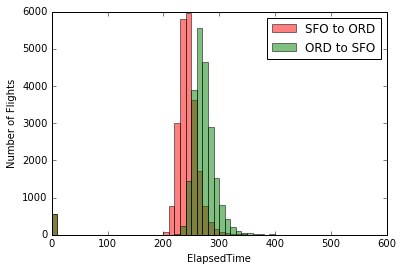

In [10]:
c = chisanfran['Count(*)'].max()

fig, ax = plt.subplots()
plot1 = ax.bar(chisanfran[chisanfran['Origin'] == 'SFO'].BucketDep, chisanfran[chisanfran['Origin'] == 'SFO']['Count(*)'], width = 10,  color = 'r', alpha = .5)
#plot1.legend("SFO to Ord")
plot2 = ax.bar(chisanfran[chisanfran['Origin'] == 'ORD'].BucketDep, chisanfran[chisanfran['Origin'] == 'ORD']['Count(*)'], width = 10,  color = 'g', alpha = .5)
ax.legend((plot1[0], plot2[0]), ("SFO to ORD", "ORD to SFO"))
ax.set_ylabel('Number of Flights')
ax.set_xlabel("ElapsedTime")
c

The elapsed times for flights going from chicago to San Fransico tend to be larger than flights from SFO to ORD. This means typically it takes longer to fly from chicago to san fransico than from san fransicso to chicago.

## Question 4 (35 points)

Are older planes more likely to be delayed? Make an appropriate graphic and summarize your conclusions in words. (Note: Your exact analysis might differ from your friend's, but your general conclusion should be the same.)

Hint: The ages of the planes can be determined using the `YearMfr` column in the `planes` table. Each plane is uniquely identified in the `ontime` table by its tail number (`TailNum`). You will need to look up this tail number in the `NNumber` column in `planes`.

In [11]:
query = '''
select YearMfr , TailNum , NNumber , avg(DepDelay), Count(*), (DepDelay -  AVG(DepDelay)) * (DepDelay -  AVG(DepDelay)) as unsqvar
from ontime , planes
where (TailNum == ("N" || NNumber))
group by YearMfr
'''
plane_yr = pd.read_sql(query, conn)

In [15]:
import seaborn as sns
import math
copy = plane_yr
copy['YearMfr'] = pd.to_numeric(copy['YearMfr'], errors = 'coerce')
copy2 = copy[(copy['YearMfr'] != 0.0)]


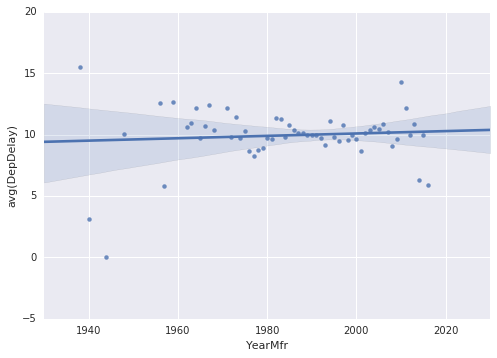

In [16]:
copy2
sns.regplot(x ='YearMfr', y = 'avg(DepDelay)' , data = copy2)

I based on the regression plot above, I wouldnt say that older planes are necessarily more inclined to be delayed than newer planes or vice versa. The regression line fit to the data is almost flat meaning there is very little correlation bestween year of the plane and avergage delay. 

## Question 5 (20 points)

Let's think about the impact of missing data on your answer to Question 4. First, answer the following:

- What percentage of planes in the `ontime` table were missing from the `planes` table?
- What percentage of flights in the `ontime` table had planes that were missing from the `planes` table?

(You should think carefully about the difference between these two questions.) Then, answer the following:

- How could this missing data bias your conclusion about the relationship between the age of a plane and flight delays?

In [3]:
query = '''
select TailNum, Count(*)
from ontime
group by TailNum
'''
planecount = pd.read_sql(query, conn)

In [4]:
query2 = '''
select  TailNum , NNumber, Count(*)
from ontime, planes
where TailNum = ("N" || NNUmber)
group by TailNum
'''

plane2 = pd.read_sql(query2, conn)

In [7]:

planes = 1 - plane2['TailNum'].count() / planecount['TailNum'].count()
flights = 1 - plane2['Count(*)'].sum() / planecount['Count(*)'].sum()

print(" flights in the ontime table had planes that were missing from the planes table %f" % flights)
print("percentage of planes in the ontime table were missing from the planes table %f" % planes)

 flights in the ontime table had planes that were missing from the planes table 0.334893
percentage of planes in the ontime table were missing from the planes table 0.411623


The data could be heavily biased if the 33 % of flights that were missing from the planes table were from a specific narrow interval of time. The percentage calculated indicate tha there are quite a few plane models and flights unaccounted for in the final data set and if there ius a reason ffor this such as bad reporting in the early data keeping then the answers could be heavily biased. PErhaps if we had less missing data we would of seen a difference between the average delay and across years. 

## Submitting this Lab

Now, restart your kernel and re-run your entire notebook from beginning to end. Make sure there are no errors or bugs. When you have verified this, open the Terminal on JupyterHub and type 

`nbgrader submit Lab-04-26 --course dlsun`

to submit this lab.